### Урок 7

In [1081]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [1082]:
# Расчет медианы по группам категории
def code_median(df, cat_feature, real_feature):
    return (df[cat_feature].map(df.groupby(cat_feature)[real_feature].median()))

### 1.  Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

Данные взяты отсюда: https://www.kaggle.com/c/choose-tutors

Посмотрим, что это за данные:

In [1083]:
train_df = pd.read_csv('train.csv')
train_df.head(3)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0


In [1084]:
predict_df = pd.read_csv('test.csv')
predict_df.head(3)

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,10000,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,10001,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,10002,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0


In [1085]:
example = pd.read_csv('submission_example.csv')
example.head(3)

,Id,choose
0,10000,0.5
1,10001,0.5
2,10002,0.5


Проверим, есть ли пропуски и формат у данных:

In [1086]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
 12  choose               10000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [1087]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   years_of_experience  10000 non-null  float64
 3   lesson_price         10000 non-null  float64
 4   qualification        10000 non-null  float64
 5   physics              10000 non-null  float64
 6   chemistry            10000 non-null  float64
 7   biology              10000 non-null  float64
 8   english              10000 non-null  float64
 9   geography            10000 non-null  float64
 10  history              10000 non-null  float64
 11  mean_exam_points     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


Пропусков нет, данные представлены в числовом формате, все ОК. Преименуем некоторые особо длинные поля, чтобы не мучиться.

In [1088]:
train_df = train_df.rename(columns={'years_of_experience': 'experience', 'lesson_price': 'price', 'mean_exam_points': 'points'})
predict_df = predict_df.rename(columns={'years_of_experience': 'experience', 'lesson_price': 'price', 'mean_exam_points': 'points'})

### 2. Сделать обзорный анализ выбранного датасета

#### Целевая переменная

In [1089]:
train_df.choose.value_counts()

0    8891
1    1109
Name: choose, dtype: int64

У нас очень несбалансированная выборка. Сбалансируем ее, создав дубликаты наименее представленного класса.

In [1090]:
p = len(train_df.loc[train_df['choose'] == 1])
n = len(train_df.loc[train_df['choose'] == 0])

In [1091]:
for i in range(0, int(n/p-1)):
    sample = train_df[train_df['choose'] == 1].sample(p)
    train_df = train_df.append(sample, ignore_index=True)

In [1092]:
train_df.choose.value_counts()

0    8891
1    8872
Name: choose, dtype: int64

Построим матрицу взаимосвязи признаков.

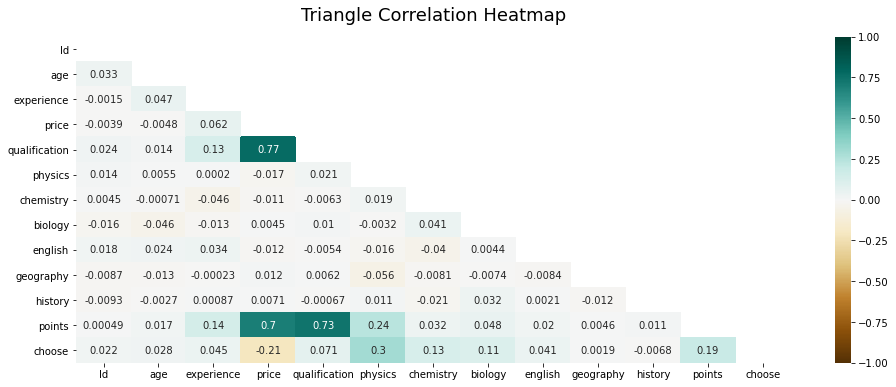

In [1093]:
plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool)) 
heatmap = sns.heatmap(train_df.corr(), annot=True, vmin=-1, vmax=1, mask = mask, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Целевой показатель у нас 'choose'. И матрица не выявила особо сильной связи этого показателя с другими (да, есть взаимосвязь с признаками - price, physics, points). Но она не настолько сильная, как хотелось бы. 

Проанализируем каждый из признаков в отдельности:

#### Age

In [1094]:
age_mean = round(train_df['age'].mean(), 2)
age_median = train_df['age'].median()
age_mode = train_df['age'].mode()[0]
print(f'mean - {age_mean}, median - {age_median}, mode - {age_mode}')

mean - 45.98, median - 46.0, mode - 44.0


Text(0.5, 1.0, 'Распределение репетиторов по возрасту')

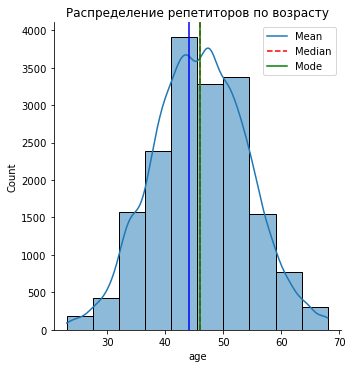

In [1095]:
sns.displot(train_df['age'], bins=10, kde=True)
plt.axvline(age_mean, color='r', linestyle='--')
plt.axvline(age_median, color='g', linestyle='-')
plt.axvline(age_mode, color='b', linestyle='-')
plt.legend({'Mean':age_mean,'Median':age_median,'Mode':age_mode})
plt.title('Распределение репетиторов по возрасту')

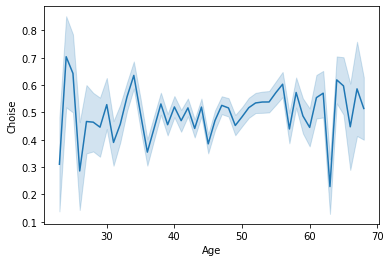

In [1096]:
lineplot = sns.lineplot(x = 'age', y ='choose', data=train_df)
lineplot.set_xlabel('Age');
lineplot.set_ylabel ('Choise');

In [1097]:
train_df['age_group'] = pd.cut(train_df['age'], bins=[1, 27, 35, 50, 60, 100], labels=[1,2,3,4,5], right=False).astype('float')
predict_df['age_group'] = pd.cut(predict_df['age'], bins=[1, 27, 35, 50, 60, 100], labels=[1,2,3,4,5], right=False).astype('float')

#### Experience

In [1098]:
exp_mean = round(train_df['experience'].mean(), 2)
exp_median = train_df['experience'].median()
exp_mode = train_df['experience'].mode()[0]
print(f'mean - {exp_mean}, median - {exp_median}, mode - {exp_mode}')

mean - 2.04, median - 2.0, mode - 0.0


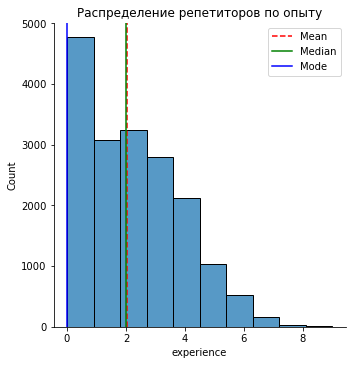

In [1099]:
sns.displot(train_df['experience'], bins=10)
plt.axvline(exp_mean, color='r', linestyle='--')
plt.axvline(exp_median, color='g', linestyle='-')
plt.axvline(exp_mode, color='b', linestyle='-')
plt.legend({'Mean':exp_mean,'Median':exp_median,'Mode':exp_mode})
plt.title('Распределение репетиторов по опыту');

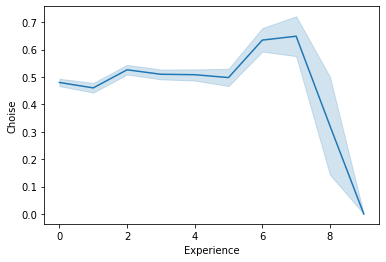

In [1100]:
lineplot = sns.lineplot(x = 'experience', y ='choose', data=train_df)
lineplot.set_xlabel('Experience');
lineplot.set_ylabel ('Choise');

In [1101]:
train_df['exp_group'] = pd.cut(train_df['experience'], bins=[0, 2, 5, 8, 15], labels=[1,2,3,4], right=False).astype('float')
predict_df['exp_group'] = pd.cut(predict_df['experience'], bins=[0, 2, 5, 8, 15], labels=[1,2,3,4], right=False).astype('float')

<font color='red'> Проверить будет ли изменение, если поменять границы групп (в частности куда отнести 8)

In [1102]:
train_df['qualification_by_exp'] = code_median(train_df, 'experience', 'qualification')
predict_df['qualification_by_exp'] = code_median(predict_df, 'experience', 'qualification')

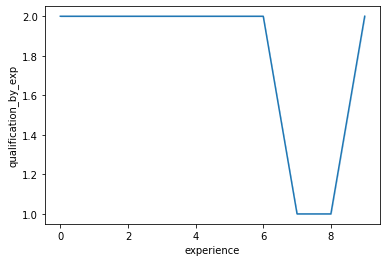

In [1103]:
lineplot = sns.lineplot(x = 'experience', y ='qualification_by_exp', data=train_df)
lineplot.set_xlabel('experience');
lineplot.set_ylabel ('qualification_by_exp');

In [1104]:
train_df['price_by_exp'] = code_median(train_df, 'experience', 'price')
predict_df['price_by_exp'] = code_median(predict_df, 'experience', 'price')

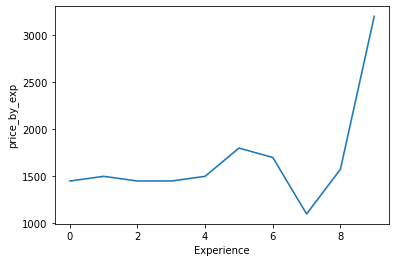

In [1105]:
lineplot = sns.lineplot(x = 'experience', y ='price_by_exp', data=train_df)
lineplot.set_xlabel('Experience');
lineplot.set_ylabel ('price_by_exp');

In [1106]:
train_df['age_by_exp_group'] = code_median(train_df, 'exp_group', 'age')
predict_df['age_by_exp_group'] = code_median(predict_df, 'exp_group', 'age')

In [1107]:
train_df['price_by_exp_group'] = code_median(train_df, 'exp_group', 'price')
predict_df['price_by_exp_group'] = code_median(predict_df, 'exp_group', 'price')

#### Price

In [1108]:
price_mean = round(train_df['price'].mean(), 2)
price_median = train_df['price'].median()
price_mode = train_df['price'].mode()[0]
print(f'mean - {price_mean}, median - {price_median}, mode - {price_mode}')

mean - 1618.77, median - 1450.0, mode - 1450.0


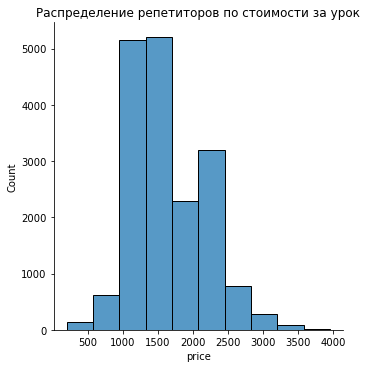

In [1109]:
sns.displot(train_df['price'], bins=10)
plt.title('Распределение репетиторов по стоимости за урок');

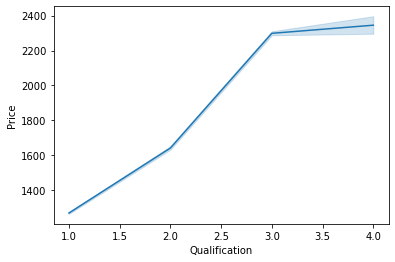

In [1110]:
lineplot = sns.lineplot(x = 'qualification', y ='price', data=train_df)
lineplot.set_xlabel('Qualification');
lineplot.set_ylabel ('Price');

In [1111]:
train_df['price_group'] = pd.cut(train_df['price'], bins=[0, 1600, 2200, 2400, 10000], labels=[1,2,3,4],right=False).astype('float')
predict_df['price_group'] = pd.cut(predict_df['price'], bins=[0, 1600, 2200, 2400, 10000], labels=[1,2,3,4],right=False).astype('float')

In [1112]:
train_df['price_by_qulification'] = code_median(train_df, 'qualification', 'price')
predict_df['price_by_qulification'] = code_median(predict_df, 'qualification', 'price')

#### Qualification

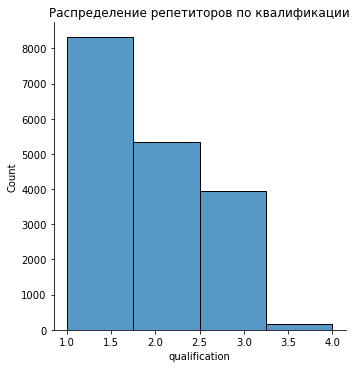

In [1113]:
sns.displot(train_df['qualification'], bins=4)
plt.title('Распределение репетиторов по квалификации');

In [1114]:
train_df['exp_by_qualification'] = code_median(train_df, 'qualification', 'experience')
predict_df['exp_by_qualification'] = code_median(predict_df, 'qualification', 'experience')

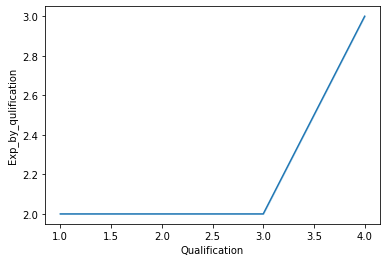

In [1115]:
lineplot = sns.lineplot(x = 'qualification', y ='exp_by_qualification', data=train_df)
lineplot.set_xlabel('Qualification');
lineplot.set_ylabel ('Exp_by_qulification');

### Science

In [1116]:
train_df['science_1'] = \
np.where(((train_df['physics'] == 1) | (train_df['chemistry'] == 1) | (train_df['biology'] == 1) | (train_df['geography'] == 1)), \
         (train_df['physics'] + train_df['chemistry'] + train_df['biology'] + train_df['geography']), 0)

In [1117]:
predict_df['science_1'] = \
np.where(((predict_df['physics'] == 1) | (predict_df['chemistry'] == 1) | (predict_df['biology'] == 1) | (predict_df['geography'] == 1)), \
         (predict_df['physics'] + predict_df['chemistry'] + predict_df['biology'] + predict_df['geography']), 0)

In [1118]:
train_df['science_2'] = \
np.where(((train_df['physics'] == 1) | (train_df['chemistry'] == 1) | (train_df['biology'] == 1) | (train_df['geography'] == 1)), \
         1, 0)

In [1119]:
predict_df['science_2'] = \
np.where(((predict_df['physics'] == 1) | (predict_df['chemistry'] == 1) | (predict_df['biology'] == 1) | (predict_df['geography'] == 1)), \
         1, 0)

In [1120]:
train_df['science_3'] = \
np.where(((train_df['physics'] == 1) | (train_df['chemistry'] == 1) | (train_df['biology'] == 1)), 1, 0)

In [1121]:
predict_df['science_3'] = \
np.where(((predict_df['physics'] == 1) | (predict_df['chemistry'] == 1) | (predict_df['biology'] == 1)), 1, 0)

### Points

In [1122]:
points_mean = round(train_df['points'].mean(), 2)
points_median = train_df['points'].median()
points_mode = train_df['points'].mode()[0]
print(f'mean - {points_mean}, median - {points_median}, mode - {points_mode}')

mean - 66.36, median - 65.0, mode - 62.0


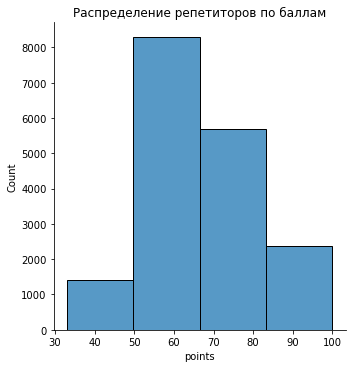

In [1123]:
sns.displot(train_df['points'], bins=4)
plt.title('Распределение репетиторов по баллам');

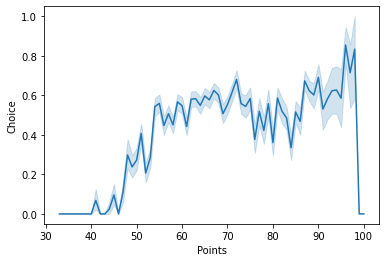

In [1124]:
lineplot = sns.lineplot(x = 'points', y ='choose', data=train_df)
lineplot.set_xlabel('Points');
lineplot.set_ylabel ('Choice');

In [1125]:
train_df['points_group'] = pd.cut(train_df['points'], bins=[0, 45, 55, 75, 85, 101], labels=[1,2,3,4,5], right=False).astype('float')
predict_df['points_group'] = pd.cut(predict_df['points'], bins=[0, 45, 55, 75, 85, 101], labels=[1,2,3,4,5], right=False).astype('float')

In [1126]:
train_df['points_by_exp'] = code_median(train_df, 'experience', 'points')
predict_df['points_by_exp'] = code_median(predict_df, 'experience', 'points')

In [1127]:
train_df['points_by_qualification'] = code_median(train_df, 'qualification', 'points')
predict_df['points_by_qualification'] = code_median(predict_df, 'qualification', 'points')

In [1128]:
train_df['points_by_age_group'] = code_median(train_df, 'age_group', 'points')
predict_df['points_by_age_group'] = code_median(predict_df, 'age_group', 'points')

In [1129]:
train_df['points_by_price_group'] = code_median(train_df, 'price_group', 'points')
predict_df['points_by_price_group'] = code_median(predict_df, 'price_group', 'points')

In [1130]:
train_df.head()

,Id,age,experience,price,qualification,physics,chemistry,biology,english,geography,...,price_by_qulification,exp_by_qualification,science_1,science_2,science_3,points_group,points_by_exp,points_by_qualification,points_by_age_group,points_by_price_group
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1600.0,2.0,0.0,0,0,3.0,64.0,65.0,65.0,70.0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,...,1600.0,2.0,2.0,1,1,3.0,64.0,65.0,66.0,60.0
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1300.0,2.0,1.0,1,1,3.0,65.0,60.0,64.0,70.0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1300.0,2.0,0.0,0,0,3.0,65.0,60.0,64.0,60.0
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,...,1600.0,2.0,1.0,1,1,3.0,65.0,65.0,65.0,82.0


### 3. Сделать feature engineering

In [1131]:
train_df.columns

Index(['Id', 'age', 'experience', 'price', 'qualification', 'physics',
       'chemistry', 'biology', 'english', 'geography', 'history', 'points',
       'choose', 'age_group', 'exp_group', 'qualification_by_exp',
       'price_by_exp', 'age_by_exp_group', 'price_by_exp_group', 'price_group',
       'price_by_qulification', 'exp_by_qualification', 'science_1',
       'science_2', 'science_3', 'points_group', 'points_by_exp',
       'points_by_qualification', 'points_by_age_group',
       'points_by_price_group'],
      dtype='object')

In [1132]:
len(train_df.columns)

30

In [1133]:
cols_to_drop = ['Id', 'age', 'choose', 'physics', 'chemistry', 'biology', 'english', 'geography', 'history', 'science_1',
       'science_2', 'science_3', 'age_group', 'exp_group', 'points_group']
cols = list(set(train_df.columns) - set(cols_to_drop))
base_cols = cols

In [1134]:
base_cols

['qualification_by_exp',
 'points_by_age_group',
 'price',
 'experience',
 'age_by_exp_group',
 'points',
 'points_by_qualification',
 'points_by_price_group',
 'price_group',
 'exp_by_qualification',
 'price_by_exp',
 'points_by_exp',
 'price_by_exp_group',
 'price_by_qulification',
 'qualification']

In [1135]:
len(train_df.columns) - 2 + len(base_cols) * 3 + len(base_cols_2) ** 3

198

In [1136]:
# генерируем признаки
def transform_data_1(data):
    for i1, col1 in enumerate(base_cols):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)
      #  data[col1 + '_Reciprocal'] = 1/(data[col1] + 1.1) - никогда не попадает в ТОП-60
        data[col1 + '_root'] = np.power(data[col1], 1/3)
        data[col1 + '_sqroot'] = np.power(data[col1], 1/2)
         
    return data

In [1137]:
import time
from tqdm import tqdm

for i in tqdm(range(100                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             )):
    time.sleep(0.1)
    train_tr = transform_data_1(train_df.drop(columns=['Id', 'choose']))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.66it/s]


In [1138]:
for i in tqdm(range(100)):
    time.sleep(0.1)
    predict_tr = transform_data_1(predict_df.drop(columns=['Id']))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.77it/s]


Сгенеренируем еще новые признаки, из тех, что давали хоть какую-то связь с целевым, произведя между ними арифметические операции,  в надежде на усиление связи.

In [1139]:
base_cols_2 = ['price', 'points', 'qualification', 'age', 'experience']

In [1140]:
def transform_data_2(data):
    for i1, col1 in enumerate(base_cols_2):
        for i2, col2 in enumerate(base_cols_2):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

            data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
    return data

In [1141]:
for i in tqdm(range(100)):
    time.sleep(0.1)
    train_tr = transform_data_2(train_tr)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91it/s]


In [1142]:
for i in tqdm(range(100)):
    time.sleep(0.1)
    predict_tr = transform_data_2(predict_tr)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


In [1143]:
train_tr.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17763.0,45.980521,8.108734,23.0,40.0,46.000000,52.000000,68.000000
experience,17763.0,2.037043,1.785724,0.0,0.0,2.000000,3.000000,9.000000
price,17763.0,1618.766537,514.770388,200.0,1250.0,1450.000000,2050.000000,3950.000000
qualification,17763.0,1.770365,0.820108,1.0,1.0,2.000000,2.000000,4.000000
physics,17763.0,0.489219,0.499898,0.0,0.0,0.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
experience_experience_4,17763.0,7.338175,9.956293,0.0,0.0,4.000000,9.000000,81.000000
experience_experience_11,17763.0,1.120857,1.175884,0.0,0.0,0.901388,1.613706,6.697415
experience_experience_22,17763.0,2.953230,2.417264,0.0,0.0,3.098612,4.386294,11.302585
experience_experience_33,17763.0,1.397046,0.952653,0.0,0.0,1.668596,2.018443,3.745965


### 4. Обучить любой классификатор (какой вам нравится)

In [1144]:
X = train_tr
y = train_df['choose']
X_predict = predict_tr

In [1145]:
X.shape, y.shape

((17763, 273), (17763,))

In [1146]:
X_train_b, X_test_b, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [1147]:
X_train_b.shape, y_train.shape, X_test_b.shape, y_test.shape

((12434, 273), (12434,), (5329, 273), (5329,))

In [1148]:
features_selection = train_tr.columns

In [1149]:
X_train = X_train_b[features_selection].to_numpy()
X_test = X_test_b[features_selection].to_numpy()
X_train.shape, X_test.shape

((12434, 273), (5329, 273))

In [1150]:
X_predict = predict_tr
X_predict = X_predict[features_selection].to_numpy()
X_predict.shape

(10000, 273)

In [1151]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_predict = StandardScaler().fit_transform(X_predict)

In [1152]:
logreg = LogisticRegression(random_state = 42, max_iter = 10000)

In [1153]:
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [1154]:
y_pred_test = logreg.predict(X_test)

In [1155]:
logreg.score(X_train, y_train)

0.7768216181437992

In [1156]:
logreg.score(X_test, y_test)

0.781384875211109

In [1157]:
preds = logreg.predict_proba(X_test)[:, 1]

In [1158]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.360281, F-Score=0.799, Precision=0.710, Recall=0.913


### Формирование файла с ответами:

In [1159]:
y_pred = logreg.predict(X_predict)

In [1160]:
submit = pd.concat([predict_df['Id'], pd.Series(y_pred)], axis = 1)
submit = submit.rename(columns = {0 : 'choose'})

In [1161]:
submit.to_csv('LogLoss_predict.csv', index=None)

In [1162]:
# comparison = []

In [1163]:
# comparison.append(['LG_100', 0.7412739263310278, 0.7468568211671983, 0.400276, 0.780, 0.698, 0.885, 0.75529, 51])
# 100 признаков, без rfe, logreg

In [1164]:
# comparison.append(['LG_60', 0.7452147337944346, 0.7549258772752862, 0.391818, 0.779, 0.682, 0.908, 0.75119, 51])
# 60 признаков, rfe, logreg

In [1165]:
# comparison.append(['LG_145', 0.7451343091523243, 0.7492963032463877, 0.417123, 0.780, 0.708, 0.868, 0.75371, 51])
# 145 признаков, без rfe, logreg

In [1166]:
# comparison.append(['LG_145_scaled', 0.7721569889013994, 0.7727528617001314, 0.380175, 0.796, 0.717, 0.894, 0.74611, 54])
# 145 признаков, без rfe, logreg

### SHAP

Разобраться с SHAP и построить важности признаков для: <br>
- всего тестового набора данных (summary_plot - дать интерпретацию) <br>
- для топ 10% <br>
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат <br>

In [1167]:
import shap
shap.initjs()

In [1168]:
explainer = shap.Explainer(logreg, X_train, feature_names=features_selection)
shap_values = explainer(X_test)

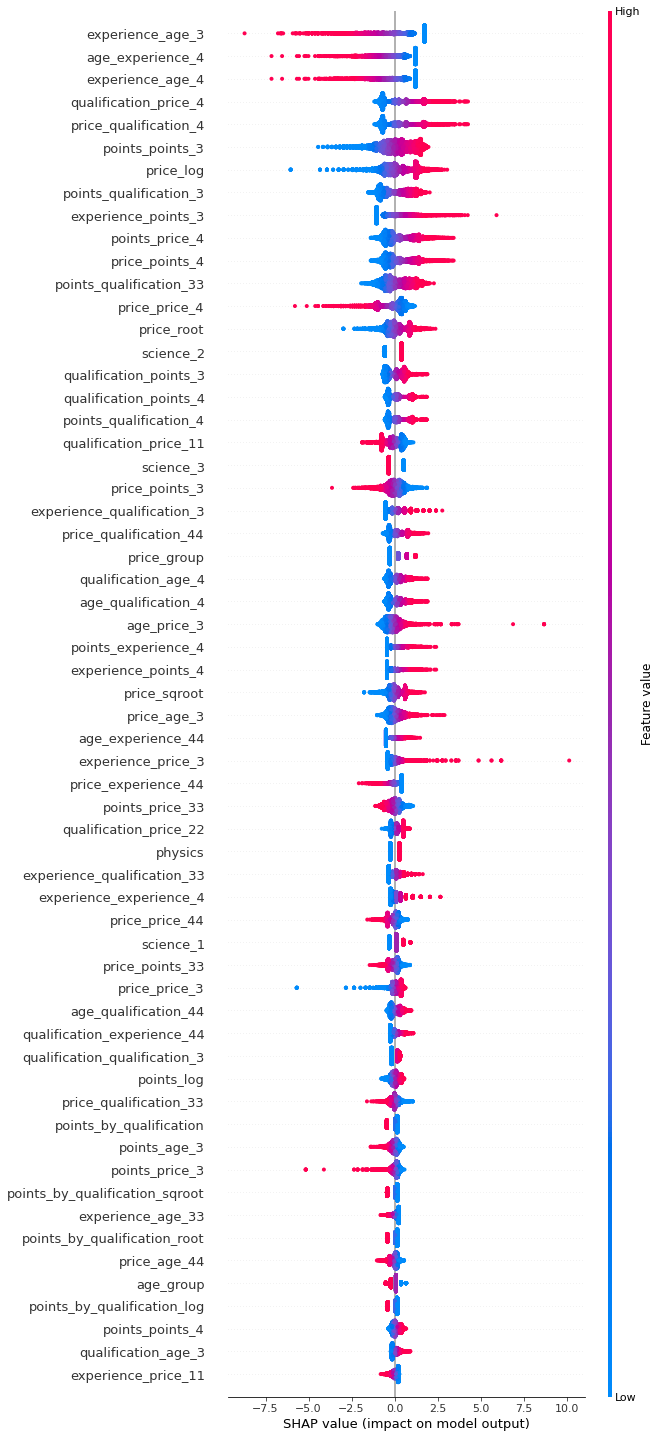

In [1169]:
shap.summary_plot(shap_values, X_test, max_display=60)

Слева от центральной линии - negative class, справа - positive class. Чем толще линия на графике, тем больше таких точек наблюдения. Чем краснее точки на графике, тем выше значения фичи в ней.

In [1170]:
shap.force_plot(explainer.expected_value, shap_values.values[10,:], X_test[10,:])

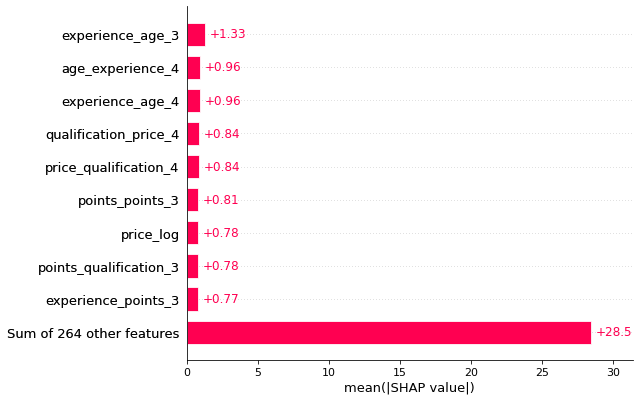

In [1171]:
shap.plots.bar(shap_values)

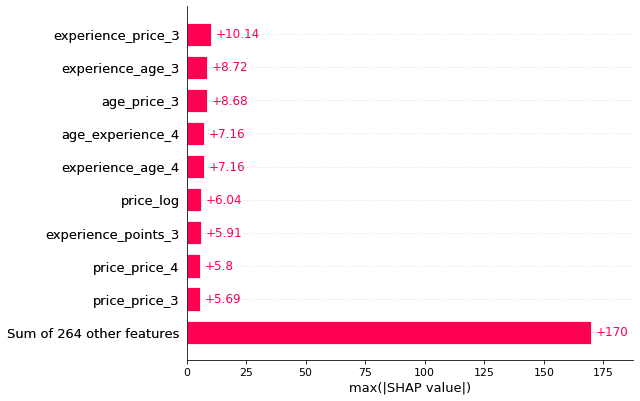

In [1172]:
shap.plots.bar(shap_values.abs.max(0))

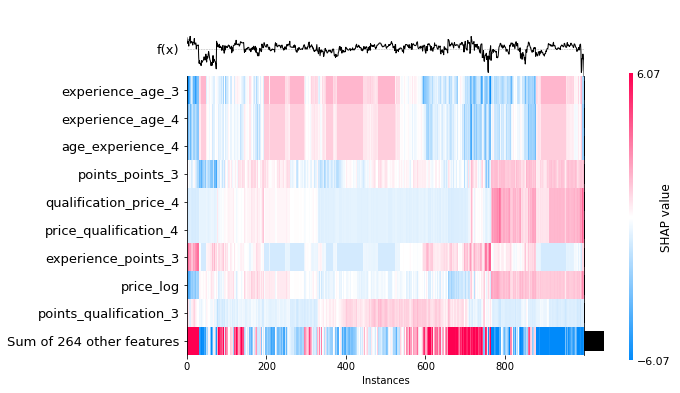

In [1173]:
shap.plots.heatmap(shap_values[:1000])